# Minimum Snap Trajectory

## Overview
Notebook and code to derive a minimum snap trajectory.

TODO: derive formulae, cite references, etc.

We want a trajectory defining position of the form:  
$x(t) = c_7t^7 + c_6t^6 + c_5t^5 + c_4t^4 + c_3t^3 + c_2t^2 + c_1t + c_0$

Once we derive the coefficients, we can then differentiate the resulting polynomial to get the desired velocity and acceleration polynomials, and use these to calculate the desired position, velocity, and accelerations at any time $t$ to give us a minimum snap trajectory, that we can then feed into our position controller.

### Generating a Trajectory for 2 Points
For a set of 2 points a and b where the time at position a is $t_s$, and the time at position b is $t_e$, we assume that the velocity and all further time deriviates will be zero (i.e. the object following the trajectory starts and ends at rest):

|               | Position      | Velocity | Acceleration | Jerk |
| ------------- | ------------- | -------- | ------------ | ---- |
| $t = t_s$     | $a$           | 0        | 0            | 0    |
| $t = t_e$     | $b$           | 0        | 0            | 0    |

This means we will have 8 unknowns and will need 8 equations to determine the coefficients of the polynomial that will give us the minimum snap trajectory over the given time period. We will be able to evaluate the position, velocity, acceleration, and jerk equations at the start and end times to generate the required equations. Note that this will be in 1-dimension, but we can repeat the process for each dimension - e.g. if we want to generate a trajectory in 3D space, the process will be the same for x, y, and z and we can re-use the A matrix for each dimension.

The equations are as follows:  
$c_{7}t_s^7 + c_{6}t_s^6 + c_{5}t_s^5 + c_{4}t_s^4 + c_{3}t_s^3 + c_{2}t_s^2 + c_{1}t_s + c_{0} = a \\
 c_{7}t_e^7 + c_{6}t_e^6 + c_{5}t_e^5 + c_{4}t_e^4 + c_{3}t_e^3 + c_{2}t_e^2 + c_{1}t_e + c_{0} = b \\
 7c_{7}t_s^6 + 6c_{6}t_s^5 + 5c_{5}t_s^4 + 4c_{4}t_s^3 + 3c_{3}t_s^2 + 2c_{2}t_s + c_{1} = 0 \\
 7c_{7}t_e^6 + 6c_{6}t_e^5 + 5c_{5}t_e^4 + 4c_{4}t_e^3 + 3c_{3}t_e^2 + 2c_{2}t_e + c_{1} = 0 \\
 42c_{7}t_s^5 + 30c_{6}t_s^4 + 20c_{5}t_s^3 + 12c_{4}t_s^2 + 6c_{3}t_s + 2c_{2} = 0 \\
 42c_{7}t_e^5 + 30c_{6}t_e^4 + 20c_{5}t_e^3 + 12c_{4}t_e^2 + 6c_{3}t_e + 2c_{2} = 0 \\
 210c_{7}t_s^4 + 120c_{6}t_s^3 + 60c_{5}t_s^2 + 24c_{4}t_s + 6c_{3} = 0 \\
 210c_{7}t_e^4 + 120c_{6}t_e^3 + 60c_{5}t_e^2 + 24c_{4}t_e + 6c_{3} = 0$ 
 
We can form an 8x8 matrix A using the above equations, and we can let x be a column vector of the coefficients we wish to find, and b will be a column vector of the RHS. We can then form the system $Ax = b$ and then we can solve for $x = A^{-1}b$

$x = \begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 \\
c_4 \\
c_5 \\
c_6 \\
c_7
\end{bmatrix}$&nbsp;, &nbsp;&nbsp;&nbsp;
$A = \begin{bmatrix}
1 & t_s & t_s^2 & t_s^3 & t_s^4 & t_s^5 & t_s^6 & t_s^7 \\
1 & t_e & t_e^2 & t_e^3 & t_e^4 & t_e^5 & t_e^6 & t_e^7 \\
0 & 1 & 2t_s & 3t_s^2 & 4t_s^3 & 5t_s^4 & 6t_s^5 & 7t_s^6 \\
0 & 1 & 2t_e & 3t_e^2 & 4t_e^3 & 5t_e^4 & 6t_e^5 & 7t_e^6 \\
0 & 0 & 2 & 6t_s & 12t_s^2 & 20t_s^3 & 30t_s^4 & 42t_s^5 \\
0 & 0 & 2 & 6t_e & 12t_e^2 & 20t_e^3 & 30t_e^4 & 42t_e^5 \\
0 & 0 & 0 & 6 & 24t_s & 60t_s^2 & 120t_s^3 & 210t_s^4 \\
0 & 0 & 0 & 6 & 24t_e & 60t_e^2 & 120t_e^3 & 210t_e^4
\end{bmatrix}$&nbsp;, &nbsp;&nbsp;&nbsp;
$b = \begin{bmatrix}
a \\
b \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{bmatrix}$

In [1]:
import sympy
import matplotlib.pyplot as plt
import numpy as np

sympy.init_printing()

In [2]:
t, T = sympy.symbols('t, T')

# define our position and time derivatives
pos = t**7 + t**6 + t**5 + t**4 + t**3 + t**2 + t + 1
vel = pos.diff(t)
acc = vel.diff(t)
jerk = acc.diff(t)
snap = jerk.diff(t)
crac = snap.diff(t)
pop = crac.diff(t)

# print all the equations
eqs = [pos, vel, acc, jerk, snap, crac, pop]
for eq in eqs:
    display(eq)

In [3]:
# define matrix print function, courtesy of: https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [4]:
# since we want to find 8 coefficients, we will need 8 equations, so we can evaluate pos, velocity, acceleration and jerk at time = 0 and time = T
# we will solve the linear system Ax = b - each row of A will be the coefficients of the evaluated polynomials at the boundary conditions, 
# where the lowest index in the row, 0, corresponds to coefficient 0
numcoeffs = 8
A = np.zeros((numcoeffs, numcoeffs))

# our time range for this polynomial
startt = 1
endt = 6

# let's assume we are starting from (1, 2) and moving to (12, 9) with the above time range
start = (1, 2)
end = (12, 9)

def coeffs_for_time(equations, numcoeffs, time):
    retval = np.zeros((len(equations), numcoeffs))
    
    for ii, eq in enumerate(equations):
        # pull out the coefficients - ordered from highest to lowest poly order, e.g.: t^3, t^2, t^1, t^0
        coeffs = eq.as_poly().all_coeffs()
        
        # apply time
        exp = len(coeffs) - 1
        for idx in range(len(coeffs)):
            coeffs[idx] *= time**exp
            exp -= 1

        # pad out with zeros if some of the coefficients are 0
        while len(coeffs) < numcoeffs:
            coeffs.append(0)

        # reverse them to match up with our coeffs vector
        retval[ii] = list(reversed(coeffs))
    return retval

half = int(numcoeffs/2)
A[0:half,:] = coeffs_for_time(eqs[0:half], numcoeffs, startt)
A[half:,:] = coeffs_for_time(eqs[0:half], numcoeffs, endt)

# print our A matrix
print('A = [')
matprint(A)
print(']')

A = [
1  1   1    1     1     1      1       1  
0  1   2    3     4     5      6       7  
0  0   2    6    12    20     30      42  
0  0   0    6    24    60    120     210  
1  6  36  216  1296  7776  46656  279936  
0  1  12  108   864  6480  46656  326592  
0  0   2   36   432  4320  38880  326592  
0  0   0    6   144  2160  25920  272160  
]


In [5]:
# so now we can create our b vectors
bx = np.zeros((numcoeffs, 1))
by = np.zeros((numcoeffs, 1))

bx[0] = start[0]
bx[half] = end[0]
by[0] = start[1]
by[half] = end[1]

# print out our b vectors
print('bx = [')
matprint(bx)
print(']\n\nby = [')
matprint(by)
print(']')

bx = [
 1  
 0  
 0  
 0  
12  
 0  
 0  
 0  
]

by = [
2  
0  
0  
0  
9  
0  
0  
0  
]


In [6]:
# now we can solve for the coefficients
bxc = np.linalg.solve(A, bx)
byc = np.linalg.solve(A, by)
print('bxc = [')
matprint(bxc)
print(']\n\nbyc = [')
matprint(byc)
print(']')

bxc = [
  1.96378  
 -4.25779  
  7.45114  
 -6.50496  
  2.93216  
-0.650496  
 0.068992  
-0.002816  
]

byc = [
  2.61331  
  -2.7095  
  4.74163  
 -4.13952  
  1.86592  
-0.413952  
 0.043904  
-0.001792  
]


In [7]:
# define a plotting function
def plot_all(tvals, xpoly, ypoly):
    xvals = [xpoly.eval(tval) for tval in tvals]
    yvals = [ypoly.eval(tval) for tval in tvals]
    
    plt.figure(figsize=(20, 24))

    plt.subplot(6, 2, 1)
    plt.plot(tvals, xvals, 'r')
    plt.ylabel('X position (m)')
    plt.grid(True)

    plt.subplot(6, 2, 2)
    plt.plot(tvals, yvals, 'b')
    plt.ylabel('Y position (m)')
    plt.grid(True)
    
    # differentiate and evaluate to get velocity
    xvals = [xpoly.diff(t).eval(tval) for tval in tvals]
    yvals = [ypoly.diff(t).eval(tval) for tval in tvals]
    
    plt.subplot(6, 2, 3)
    plt.plot(tvals, xvals, 'g')
    plt.ylabel('X velocity (m/s)')
    plt.grid(True)

    plt.subplot(6, 2, 4)
    plt.plot(tvals, yvals, 'y')
    plt.ylabel('Y velocity (m/s)')
    plt.grid(True)
    
    # differentiate twice and evaluate to get acceleration
    xvals = [xpoly.diff(t).diff(t).eval(tval) for tval in tvals]
    yvals = [ypoly.diff(t).diff(t).eval(tval) for tval in tvals]
    
    plt.subplot(6, 2, 5)
    plt.plot(tvals, xvals, 'm')
    plt.xlabel('time (s)')
    plt.ylabel('X acceleration (m/s^2)')
    plt.grid(True)

    plt.subplot(6, 2, 6)
    plt.plot(tvals, yvals, 'c')
    plt.xlabel('time (s)')
    plt.ylabel('Y acceleration (m/s^2)')
    plt.grid(True)
    
    plt.show()

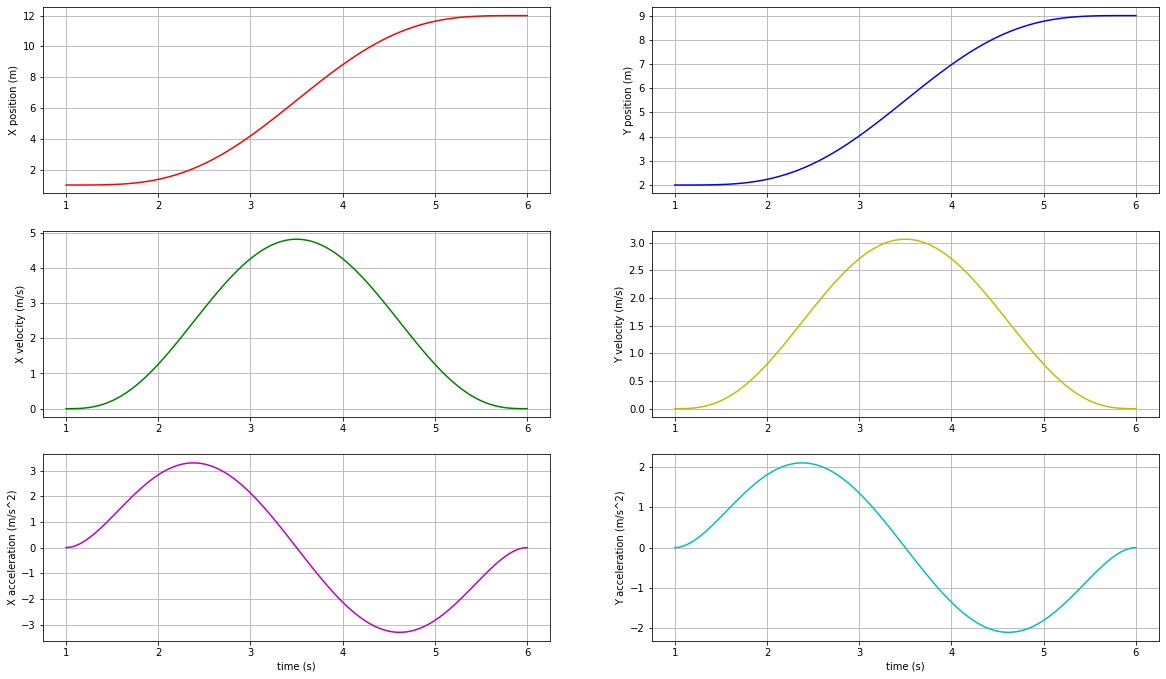

In [8]:
# create the polynomials so we can differentiate them to get our various commanded position, velocity and accelleration curves
bxpoly = sympy.Poly(reversed(bxc.transpose()[0]), t)
bypoly = sympy.Poly(reversed(byc.transpose()[0]), t)

# create our t values over the specified range
tvals = np.linspace(startt, endt, 100)

# display the position, velocity and acceleration curves
plot_all(tvals, bxpoly, bypoly)

### Multi-point Trajectories

For trajectories that contain $n$ points, we will need to generate $n-1$ polynomials. This means we will need to find $8(n-1)$ coefficients - where each set of 8 corresponds to one segment. So we must form $8(n-1)$ equations in order to solve for the coefficients, where coefficients for segment $i$ are:  
$c_{i,7}, c_{i,6}, c_{i,5}, c_{i,4}, c_{i,3}, c_{i,2}, c_{i,1}, c_{i,0}$

The boundary conditions are slightly different in this case, since we don't want the trajectory to stop at intermediary points but smoothly traverse through them - so we want to ensure that the transitions between polynomials is continuous.

For a set of points, we will also assume we have a desired time when each point should be reached. For a set of n points, we will also have n times, where the following condition is satisifed:  
$t_{i-1} < t_i < t_{i+1}$

For all segments, we know that the polynomial must pass through the start and end point for that segment. This gives us $2(n-1)$ equations, so for any segment $i$ with point $a_i$:  
$c_{i,7}t_i^7 + c_{i,6}t_i^6 + c_{i,5}t_i^5 + c_{i,4}t_i^4 + c_{i,3}t_i^3 + c_{i,2}t_i^2 + c_{i,1}t_i + c_{i,0} = a_i \\
c_{i,7}t_{i+1}^7 + c_{i,6}t_{i+1}^6 + c_{i,5}t_{i+1}^5 + c_{i,4}t_{i+1}^4 + c_{i,3}t_{i+1}^3 + c_{i,2}t_{i+1}^2 + c_{i,1}t_{i+1} + c_{i,0} = a_{i+1}$

Each segment, except for the last, will have the condition that at it's end time, the velocity and all its further time derivatives, will equal the velocity, and all its further time derivatives of the following segment's start time. If we use velocity, acceleration, jerk, snap, crackle and pop, we will have a further $6(n-2)$ equations:  
$7c_{i,7}t_{i+1}^6 + 6c_{i,6}t_{i+1}^5 + 5c_{i,5}t_{i+1}^4 + 4c_{i,4}t_{i+1}^3 + 3c_{i,3}t_{i+1}^2 + 2c_{i,2}t_{i+1} + c_{i,1} = 7c_{i+1,7}t_{i+1}^6 + 6c_{i+1,6}t_{i+1}^5 + 5c_{i+1,5}t_{i+1}^4 + 4c_{i+1,4}t_{i+1}^3 + 3c_{i+1,3}t_{i+1}^2 + 2c_{i+1,2}t_{i+1} + c_{+1i,1} \\
42c_{i,7}t_{i+1}^5 + 30c_{i,6}t_{i+1}^4 + 20c_{i,5}t_{i+1}^3 + 12c_{i,4}t_{i+1}^2 + 6c_{i,3}t_{i+1} + 2c_{i,2} = 42c_{i+1,7}t_{i+1}^5 + 30c_{i+1,6}t_{i+1}^4 + 20c_{i+1,5}t_{i+1}^3 + 12c_{i+1,4}t_{i+1}^2 + 3c_{i+1,3}t_{i+1} + 2c_{i+1,2} \\
210c_{i,7}t_{i+1}^4 + 120c_{i,6}t_{i+1}^3 + 60c_{i,5}t_{i+1}^2 + 24c_{i,4}t_{i+1} + 6c_{i,3} = 210c_{i+1,7}t_{i+1}^4 + 120c_{i+1,6}t_{i+1}^3 + 60c_{i+1,5}t_{i+1}^2 + 24c_{i+1,4}t_{i+1} + 6c_{i+1,3} \\
840c_{i,7}t_{i+1}^3 + 360c_{i,6}t_{i+1}^2 + 120c_{i,5}t_{i+1} + 24c_{i,4} = 840c_{i+1,7}t_{i+1}^3 + 360c_{i+1,6}t_{i+1}^2 + 120c_{i+1,5}t_{i+1} + 24c_{i+1,4} \\
2520c_{i,7}t_{i+1}^2 + 720c_{i,6}t_{i+1} + 120c_{i,5} = 2520c_{i+1,7}t_{i+1}^2 + 720c_{i+1,6}t_{i+1} + 120c_{i+1,5} \\
5040c_{i,7}t_{i+1} + 720c_{i,6}t_{i+1} = 5040c_{i+1,7}t_{i+1} + 720c_{i+1,6}$

or, by moving all terms to LHS:

$7c_{i,7}t_{i+1}^6 + 6c_{i,6}t_{i+1}^5 + 5c_{i,5}t_{i+1}^4 + 4c_{i,4}t_{i+1}^3 + 3c_{i,3}t_{i+1}^2 + 2c_{i,2}t_{i+1} + c_{i,1} - 7c_{i+1,7}t_{i+1}^6 - 6c_{i+1,6}t_{i+1}^5 - 5c_{i+1,5}t_{i+1}^4 - 4c_{i+1,4}t_{i+1}^3 - 3c_{i+1,3}t_{i+1}^2 - 2c_{i+1,2}t_{i+1} - c_{i+1,1} = 0 \\
42c_{i,7}t_{i+1}^5 + 30c_{i,6}t_{i+1}^4 + 20c_{i,5}t_{i+1}^3 + 12c_{i,4}t_{i+1}^2 + 6c_{i,3}t_{i+1} + 2c_{i,2} - 42c_{i+1,7}t_{i+1}^5 - 30c_{i+1,6}t_{i+1}^4 - 20c_{i+1,5}t_{i+1}^3 - 12c_{i+1,4}t_{i+1}^2 - 3c_{i+1,3}t_{i+1} - 2c_{i+1,2} = 0 \\
210c_{i,7}t_{i+1}^4 + 120c_{i,6}t_{i+1}^3 + 60c_{i,5}t_{i+1}^2 + 24c_{i,4}t_{i+1} + 6c_{i,3} - 210c_{i+1,7}t_{i+1}^4 - 120c_{i+1,6}t_{i+1}^3 - 60c_{i+1,5}t_{i+1}^2 - 24c_{i+1,4}t_{i+1} - 6c_{i+1,3} = 0 \\
840c_{i,7}t_{i+1}^3 + 360c_{i,6}t_{i+1}^2 + 120c_{i,5}t_{i+1} + 24c_{i,4} - 840c_{i+1,7}t_{i+1}^3 - 360c_{i+1,6}t_{i+1}^2 - 120c_{i+1,5}t_{i+1} - 24c_{i+1,4} = 0 \\
2520c_{i,7}t_{i+1}^2 + 720c_{i,6}t_{i+1} + 120c_{i,5} - 2520c_{i+1,7}t_{i+1}^2 - 720c_{i+1,6}t_{i+1} - 120c_{i+1,5} = 0 \\
5040c_{i,7}t_{i+1} + 720c_{i,6}t_{i+1} - 5040c_{i+1,7}t_{i+1} - 720c_{i+1,6} = 0$

We now only need 6 more equations which we can get from the first and last segments:  
* the first segment will have zero velocity, acceleration and jerk for its start point - this gives us 3 more equations  
  $7c_{0,7}t_0^6 + 6c_{0,6}t_0^5 + 5c_{0,5}t_0^4 + 4c_{0,4}t_0^3 + 3c_{0,3}t_0^2 + 2c_{0,2}t_0 + c_{0,1} = 0 \\
  42c_{0,7}t_0^5 + 30c_{0,6}t_0^4 + 20c_{0,5}t_0^3 + 12c_{0,4}t_0^2 + 6c_{0,3}t_0 + 2c_{0,2} = 0 \\
  210c_{0,7}t_0^4 + 120c_{0,6}t_0^3 + 60c_{0,5}t_0^2 + 24c_{0,4}t_0 + 6c_{0,3} = 0$
* the last segment will have zero velocity, acceleration and jerk for its its end point. This gives us 3 more equation  
  $7c_{n-1,7}t_{n-1}^6 + 6c_{n-1,6}t_{n-1}^5 + 5c_{n-1,5}t_{n-1}^4 + 4c_{n-1,4}t_{n-1}^3 + 3c_{n-1,3}t_{n-1}^2 + 2c_{n-1,2}t_{n-1} + c_{n-1,1} = 0 \\
  42c_{n-1,7}t_{n-1}^5 + 30c_{n-1,6}t_{n-1}^4 + 20c_{n-1,5}t_{n-1}^3 + 12c_{n-1,4}t_{n-1}^2 + 6c_{n-1,3}t_{n-1} + 2c_{n-1,2} = 0 \\
  210c_{n-1,7}t_{n-1}^4 + 120c_{n-1,6}t_{n-1}^3 + 60c_{n-1,5}t_{n-1}^2 + 24c_{n-1,4}t_{n-1} + 6c_{n-1,3} = 0$

Once we have the above equations evaluated at the correct times, we can again use linear algebra to determine the set of polynomial coefficients to give us a minimum snap trajectory over multiple points, where the intermediary points will transition smoothly.

In [9]:
# setup our desired trajectory points and times of arrival
points = [(1, 2), (12, 9), (20, 6), (25, 0)]
times = [1, 6, 11, 16]

# initialize the matrix and vectors
n = numcoeffs * (len(points) - 1)
A = np.zeros((n, n))
bx = np.zeros((n, 1))
by = np.zeros((n, 1))

# fill in 3 equations for first segment - velocity, acceleration and jerk are all equal to 0 at start time
nextrow = 0
A[nextrow:nextrow+3, 0:numcoeffs] = coeffs_for_time([vel, acc, jerk], numcoeffs, times[0])
nextrow += 3

# fill in 3 equations for last segment - velocity, acceleration and jerk are all equal to 0 at end time
A[nextrow:nextrow+3, n-numcoeffs:n] = coeffs_for_time([vel, acc, jerk], numcoeffs, times[-1])
nextrow += 3

# for all segments...
for idx, startp in enumerate(points[0:-1]):
    endp = points[idx+1]
    startt = times[idx]
    endt = times[idx+1]
    
    # fill in 2 equations for start and end point passing through the poly
    # start point
    col = idx * numcoeffs
    A[nextrow:nextrow+1, col:col+numcoeffs] = coeffs_for_time([pos], numcoeffs, startt)
    bx[nextrow] = startp[0]
    by[nextrow] = startp[1]
    nextrow += 1
    
    # end point
    A[nextrow:nextrow+1, col:col+numcoeffs] = coeffs_for_time([pos], numcoeffs, endt)
    bx[nextrow] = endp[0]
    by[nextrow] = endp[1]
    
    nextrow += 1

# for all segments, except last...
for idx in range(len(points) - 2):
    endt = times[idx+1]
    
    # fill in 6 equations for velocity, acceleration, jerk, snap, crackle and pop to ensure they are the same through the transition point
    # evaluate both poly's at the end point
    col = idx * numcoeffs
    A[nextrow:nextrow+6, col:col+numcoeffs] = coeffs_for_time([vel, acc, jerk, snap, crac, pop], numcoeffs, endt)
    col += numcoeffs
    
    # negate endt coefficients since we move everything to the lhs
    A[nextrow:nextrow+6, col:col+numcoeffs] = -coeffs_for_time([vel, acc, jerk, snap, crac, pop], numcoeffs, endt)
    nextrow += 6

# print our A matrix
print('A = [')
matprint(A)
print(']\n')

# print out our b vectors
print('bx = [')
matprint(bx)
print(']\n\nby = [')
matprint(by)
print(']')

A = [
0  1   2    3     4     5      6       7   0   0    0     0      0       0            0            0   0   0    0     0      0            0            0             0  
0  0   2    6    12    20     30      42   0   0    0     0      0       0            0            0   0   0    0     0      0            0            0             0  
0  0   0    6    24    60    120     210   0   0    0     0      0       0            0            0   0   0    0     0      0            0            0             0  
0  0   0    0     0     0      0       0   0   0    0     0      0       0            0            0   0   1   32   768  16384       327680  6.29146e+06   1.17441e+08  
0  0   0    0     0     0      0       0   0   0    0     0      0       0            0            0   0   0    2    96   3072        81920  1.96608e+06   4.40402e+07  
0  0   0    0     0     0      0       0   0   0    0     0      0       0            0            0   0   0    0     6    384        15360       491

In [10]:
# now we can solve for the coefficients
bxc = np.linalg.solve(A, bx)
byc = np.linalg.solve(A, by)
print('bxc = [')
matprint(bxc)
print(']\n\nbyc = [')
matprint(byc)
print(']')

bxc = [
      1.1525  
   -0.651643  
     1.08562  
   -0.876073  
    0.343654  
  -0.0584454  
   0.0045287  
-0.000133201  
     -51.934  
     61.2825  
    -29.8815  
      7.7259  
    -1.09001  
   0.0849208  
 -0.00343609  
 5.64367e-05  
     2914.76  
    -1826.61  
     484.999  
    -70.2863  
     6.00201  
   -0.301916  
  0.00828625  
-9.58015e-05  
]

byc = [
     2.08832  
   -0.376195  
    0.623616  
   -0.499036  
    0.192583  
  -0.0315505  
  0.00232398  
-6.49009e-05  
    -19.8009  
     25.1613  
    -12.1451  
     3.04784  
   -0.398562  
    0.027564  
-0.000960163  
 1.32929e-05  
    -75.1182  
     60.3632  
    -21.7456  
     4.50246  
     -0.5308  
    0.034777  
 -0.00117874  
 1.61316e-05  
]


In [11]:
# create our array of position polys for each segment
xpolys = []
ypolys = []
for segment in range(len(points) - 1):
    offset = segment*numcoeffs
    xpolys.append(sympy.Poly(reversed(bxc[offset:offset+numcoeffs].transpose()[0]), t))
    ypolys.append(sympy.Poly(reversed(byc[offset:offset+numcoeffs].transpose()[0]), t))

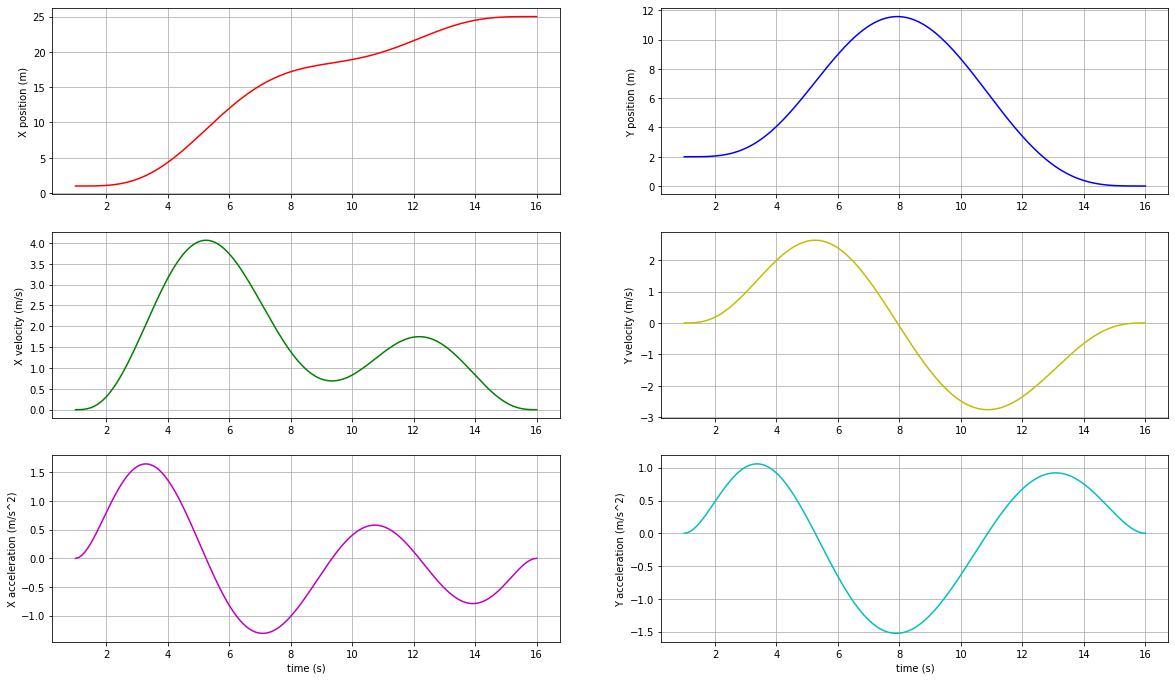

In [12]:
# now we can iterate over each of the found polynomials to get our full trajectory
samples = 50
tvals = np.linspace(times[0], times[-1], samples*(len(points) - 1))
xpos = []
ypos = []
xvel = []
yvel = []
xacc = []
yacc = []
for idx in range(len(points) - 1):
    # pull out the tvals for this segment
    currtvals = tvals[np.argwhere((tvals >= times[idx]) & (tvals <= times[idx+1]))].transpose()[0]
    
    # get the correct poly for this segment
    xpoly = xpolys[idx]
    ypoly = ypolys[idx]
    
    # evaluate at each tval for position, velocity and acceleration
    xpos += [xpoly.eval(tval) for tval in currtvals]
    ypos += [ypoly.eval(tval) for tval in currtvals]
    xvel += [xpoly.diff(t).eval(tval) for tval in currtvals]
    yvel += [ypoly.diff(t).eval(tval) for tval in currtvals]
    xacc += [xpoly.diff(t).diff(t).eval(tval) for tval in currtvals]
    yacc += [ypoly.diff(t).diff(t).eval(tval) for tval in currtvals]

# plot the results
plt.figure(figsize=(20, 24))

plt.subplot(6, 2, 1)
plt.plot(tvals, xpos, 'r')
plt.ylabel('X position (m)')
plt.grid(True)

plt.subplot(6, 2, 2)
plt.plot(tvals, ypos, 'b')
plt.ylabel('Y position (m)')
plt.grid(True)

plt.subplot(6, 2, 3)
plt.plot(tvals, xvel, 'g')
plt.ylabel('X velocity (m/s)')
plt.grid(True)

plt.subplot(6, 2, 4)
plt.plot(tvals, yvel, 'y')
plt.ylabel('Y velocity (m/s)')
plt.grid(True)

plt.subplot(6, 2, 5)
plt.plot(tvals, xacc, 'm')
plt.xlabel('time (s)')
plt.ylabel('X acceleration (m/s^2)')
plt.grid(True)

plt.subplot(6, 2, 6)
plt.plot(tvals, yacc, 'c')
plt.xlabel('time (s)')
plt.ylabel('Y acceleration (m/s^2)')
plt.grid(True)

plt.show()

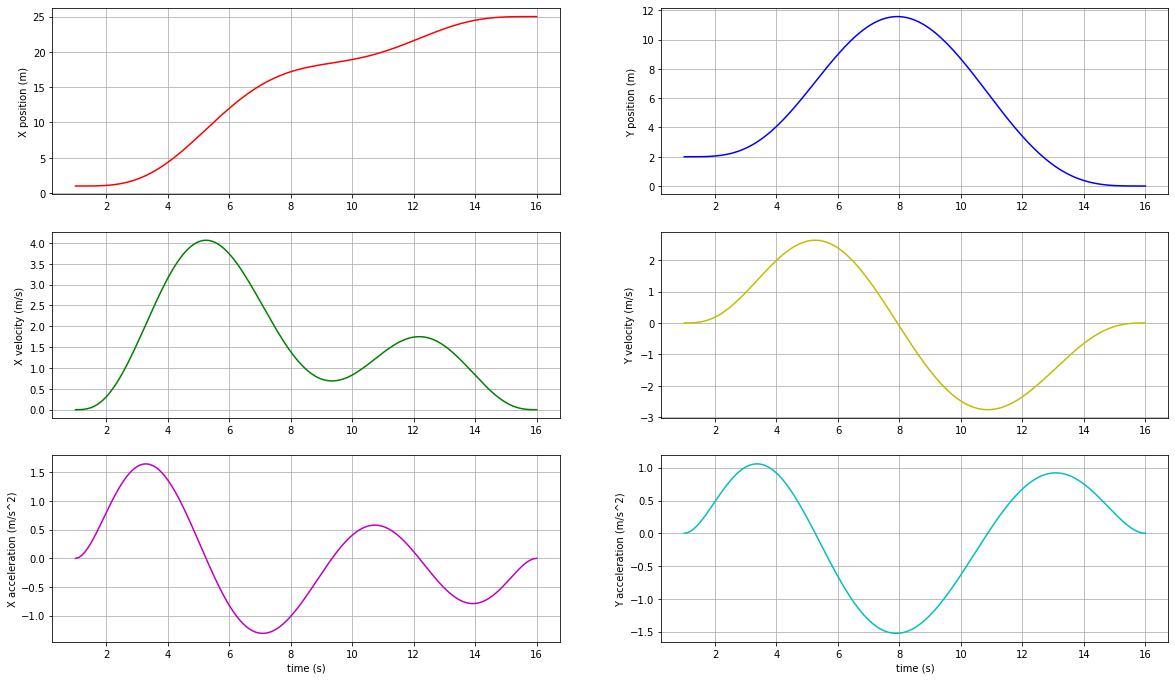

In [13]:
# plot the results
plt.figure(figsize=(20, 24))

plt.subplot(6, 2, 1)
plt.plot(tvals, xpos, 'r')
plt.ylabel('X position (m)')
plt.grid(True)

plt.subplot(6, 2, 2)
plt.plot(tvals, ypos, 'b')
plt.ylabel('Y position (m)')
plt.grid(True)

plt.subplot(6, 2, 3)
plt.plot(tvals, xvel, 'g')
plt.ylabel('X velocity (m/s)')
plt.grid(True)

plt.subplot(6, 2, 4)
plt.plot(tvals, yvel, 'y')
plt.ylabel('Y velocity (m/s)')
plt.grid(True)

plt.subplot(6, 2, 5)
plt.plot(tvals, xacc, 'm')
plt.xlabel('time (s)')
plt.ylabel('X acceleration (m/s^2)')
plt.grid(True)

plt.subplot(6, 2, 6)
plt.plot(tvals, yacc, 'c')
plt.xlabel('time (s)')
plt.ylabel('Y acceleration (m/s^2)')
plt.grid(True)

plt.show()